In [2]:
#import OpenCV module
import cv2
#import os module for reading training data directories and paths
import os
#import numpy to convert python lists to numpy arrays as 
#it is needed by OpenCV face recognizers
import numpy as np
from pathlib import Path    
#matplotlib for display our images
import matplotlib.pyplot as plt
%matplotlib inline
from numba import autojit
import random
import tensorflow as tf

In [16]:
def pooling(inputMap,poolSize=3,poolStride=None,mode='max'):
    """INPUTS:
              inputMap - input array of the pooling layer
              poolSize - X-size(equivalent to Y-size) of receptive field
              poolStride - the stride size between successive pooling squares
       
       OUTPUTS:
               outputMap - output array of the pooling layer
               
       Padding mode - 'edge'
    """
    if poolStride==None:
        poolStride=poolSize
    # inputMap sizes
    in_row,in_col = np.shape(inputMap)
    # outputMap sizes
    temp_map = inputMap
    print(temp_map)
    out_row = int(np.floor((in_row-poolSize)/poolStride)+1)
    out_col = int(np.floor((in_col-poolSize)/poolStride)+1)
    row_remainder,col_remainder = np.mod(in_row,poolStride),np.mod(in_col,poolStride)
    outputMap = np.zeros((out_row,out_col))
    outputMap1 = np.zeros((in_row,in_col))
    # padding
    if mode == "max":
    # max pooling
        for r_idx in range(0,out_row):
            for c_idx in range(0,out_col):
                startX = c_idx * poolStride
                startY = r_idx * poolStride
                poolField = temp_map[startY:startY + poolSize, startX:startX + poolSize]
                poolOut = np.max(poolField)
                outputMap[r_idx,c_idx] = poolOut
           
    # retrun outputMap
    elif mode == "lbph":
        for r_idx in range(0,out_row):
            for c_idx in range(0,out_col):
                startX = c_idx * poolStride
                startY = r_idx * poolStride
                poolField = temp_map[startY:startY + poolSize, startX:startX + poolSize]    
                a = 0
                if(poolSize%2==0):
                    if poolSize%2==0:
                        a = np.mean(poolField[int(in_row/2-1):int(in_row/2),int(in_col/2-1):int(in_col/2)])
                    else:
                        a = np.mean(poolField[int((in_row-1)/2),int(in_col/2-1):int(in_col/2)])
                else:
                    if poolSize%2==0:
                        a = np.mean(poolField[int(in_row/2-1):int(in_row/2),int((in_col-1)/2)])
                    else:
                        a = poolField[int((in_row-1)/2),int((in_col-1)/2)]
                length = poolSize*poolSize-(poolSize-2)*(poolSize-2)
                print(length)
                array = np.zeros(length)
                print(poolField)
                for x in range(poolSize-1):
                    s1 = poolField[poolSize-1,x]
                    s2 = poolField[poolSize-1-x,poolSize-1]
                    s3 = poolField[0,poolSize-1-x]
                    s4 = poolField[x,0]
                    array[x] = s1
                    array[x+poolSize-1] = s2
                    array[x+poolSize*2-2] = s3
                    array[x+poolSize*3-3] = s4
                array_zeroone=np.where(array<a,0,1)
                poolOut = 0
                for x in range(length):
                    poolOut += array_zeroone[x]*np.power(2,length-1-x)
                outputMap[r_idx,c_idx] = poolOut
    return  outputMap

#test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
#test_result = pooling(test, 3,1, 'lbph')
#print(test_result)

In [3]:
@autojit
def detect_face(img):
    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #load OpenCV face detector, I am using LBP which is fast
    #there is also a more accurate but slow Haar classifier
    face_cascade = cv2.CascadeClassifier('C:\\OpenCv\\opencv\\sources\\data\\lbpcascades\\lbpcascade_frontalface.xml')

    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    #return only the face part of the image
    cv2.imshow("Training on image...", gray[y:y+w, x:x+h])
    cv2.waitKey(100)
    return gray[y:y+w, x:x+h], faces[0]

In [17]:
img1 = cv2.imread("training-data/testdata/Alejandro_Toledo/Alejandro_Toledo_test_0002.jpg")
face,name = detect_face(img1)
face_lbph = pooling(face)
print(face_lbph)
print(np.shape(face_lbph))

[[103  75  46 ... 225 225 224]
 [ 77  70  60 ... 225 225 224]
 [ 67  62  53 ... 225 225 224]
 ...
 [ 65  65  61 ... 225 223 228]
 [ 64  61  63 ... 226 226 228]
 [ 65  57  56 ... 224 225 225]]
[[103.  41.  25. ... 225. 225. 225.]
 [ 74.  38.  25. ... 225. 225. 225.]
 [ 75.  35.  27. ... 225. 225. 225.]
 ...
 [237.  61. 181. ... 227. 227. 227.]
 [162.  54. 146. ... 227. 227. 227.]
 [ 70.  55.  95. ... 230. 228. 230.]]
(46, 46)


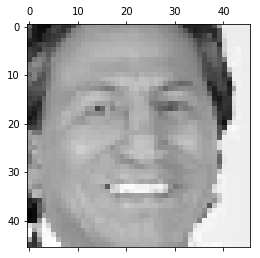

In [18]:
import matplotlib.pyplot as plt

plt.matshow(face_lbph, cmap='gray')

[[103.  41.  25. ... 225. 225. 225.]
 [ 74.  38.  25. ... 225. 225. 225.]
 [ 75.  35.  27. ... 225. 225. 225.]
 ...
 [237.  61. 181. ... 227. 227. 227.]
 [162.  54. 146. ... 227. 227. 227.]
 [ 70.  55.  95. ... 230. 228. 230.]]


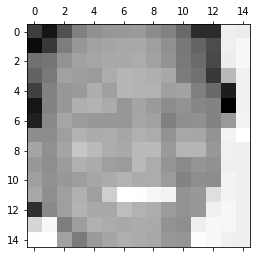

In [19]:
face_lbph_2 = pooling(face_lbph)
plt.matshow(face_lbph_2, cmap='gray')

[[103.  75. 116. 150. 161. 166. 167. 168. 158. 151. 134.  91.  91. 228.
  226.]
 [ 67.  99. 148. 166. 174. 176. 179. 178. 172. 161. 144. 131. 113. 229.
  234.]
 [139. 142. 163. 173. 177. 179. 179. 181. 174. 164. 145. 135. 110. 227.
  235.]
 [129. 145. 173. 171. 169. 181. 188. 186. 183. 178. 147. 139. 100. 190.
  230.]
 [105. 151. 166. 168. 182. 172. 188. 186. 186. 172. 175. 149. 134.  80.
  230.]
 [ 74. 153. 167. 183. 186. 180. 166. 176. 168. 159. 164. 155. 152.  59.
  229.]
 [ 82. 156. 177. 169. 167. 166. 166. 177. 173. 150. 160. 162. 153. 168.
  232.]
 [159. 158. 172. 185. 180. 181. 177. 184. 181. 164. 178. 177. 164. 232.
  240.]
 [176. 161. 176. 199. 191. 182. 179. 190. 191. 168. 187. 187. 167. 229.
  228.]
 [167. 160. 170. 184. 180. 172. 169. 190. 181. 165. 157. 165. 162. 228.
  228.]
 [172. 162. 167. 171. 177. 180. 186. 180. 181. 169. 153. 160. 158. 232.
  228.]
 [178. 160. 172. 184. 172. 205. 240. 239. 234. 232. 163. 167. 217. 232.
  228.]
 [ 94. 156. 172. 186. 179. 178. 193. 185

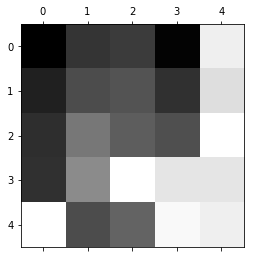

In [20]:
face_lbph_3 = pooling(face_lbph_2)
plt.matshow(face_lbph_3, cmap='gray')